# Coursework 2 Part 1
**Replace CID in the file name with your CID**

# Outline


- [Task 1](#task-1): Dimensionality Reduction and Regression with Convolutional Neural Networks - CNNs
 <a name="index-task-1"></a>
  - [(1.1)](#task-11) <a name="index-task-11"></a>
  - [(1.2)](#task-12) <a name="index-task-12"></a>
- [Task 2](#task-2): Graph-based learning <a name="index-task-2"></a>
  - [(2.1)](#task-21) <a name="index-task-21"></a>
  - [(2.2)](#task-22)  <a name="index-task-22"></a>

---

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import TensorDataset, DataLoader

<a name="task-1"></a>

# Task 1: Dimensionality Reduction and Regression with Convolutional Neural Networks - CNNs [(index)](#index-task-1)

<a name="task-11"></a>

## (1.1) [(index)](#index-task-11)

In [8]:
# torch.manual_seed(0)

dataset = pd.read_csv("gene_expression_transcriptomic_data.csv")

X = dataset.iloc[:, :-2].values
y = dataset.iloc[:, -2].values

# Reshape each sample from an array of 100 features to a 2-dimensional matrix of 10×10 pixels
X_square = X.reshape(X.shape[0], 10, 10)

# Split the data into training, validation, and test sets
X_train = X_square[:1848]
y_train = y[:1848]

X_val = X_square[1848: 1848 + 264]
y_val = y[1848: 1848 + 264]

X_test = X_square[1848 + 264:]
y_test = y[1848 + 264:]

In [9]:
# Define a UNet class as a child class of nn.Module to create a custom neural network model for the UNet architecture
class UNet(nn.Module):
    """
    Create a UNet neural network model.

    Attributes:
        conv1, conv2, conv3, conv4: The convolutional layers in the UNet arcitechture
        pool: The max-pooling layer in the contracting path
        upconv: The upsampling transposed convolutional layer

    Methods:
        forward(x):
            Initialise the layers for the forward pass.
    """
    def __init__(self):
        super(UNet, self).__init__()
        
        # Define the layers for the contracting path
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        
        # Define the layers for the expanding path
        self.upconv = nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv3 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(8, 1, kernel_size=1)

    def forward(self, x):
        # Forward pass through the contracting path
        x1 = torch.relu(self.conv1(x))
        x_pooled = self.pool(x1)
        x2 = torch.relu(self.conv2(x_pooled))
        
        # Forward pass through the expanding path
        x3 = torch.relu(self.upconv(x2))
        
        # Skip connection: concatenate x1 (the output of the 3x3 convolutional layer and ReLU) to x3 (the output of the expanding path)
        # Intuitively the copy and crop recovers lost info from the contracting path (I think?)
        x4 = torch.cat([x3, x1], dim=1)
        x5 = torch.relu(self.conv3(x4))
        output = self.conv4(x5)
        
        return output

In [10]:
# Define the MSE_reconstruct loss function as a class
# This allows us to use MSEReconstructLoss() just like CrossEntropyLoss() in the CNNs Notebook
class MSEReconstructLoss(nn.Module):
    """
    Computes the MSE_reconstruct loss:

    Attributes:
        None.

    Methods:
        forward(output, target):
            Returns the MSEReconstruct loss through the forward pass, just like how other loss functions are implemented in PyTorch.
    """
    
    def __init__(self):
        super(MSEReconstructLoss, self).__init__()
    
    def forward(self, output, target):
        
        # Reshape tensors to (batch_size, 100)
        batch_size = output.shape[0]
        output_flat = output.reshape(batch_size, -1)
        target_flat = target.reshape(batch_size, -1)
        
        # Calculate squared differences for each feature
        squared_diff = (output_flat - target_flat) ** 2
        
        # Sum over features for each sample
        sample_mse = torch.sum(squared_diff, dim=1)
        
        # Average over batch
        mse_reconstruct = torch.mean(sample_mse)
        
        return mse_reconstruct

In [11]:
# Function copied from CNNs Notebook
class EarlyStopping:
    """
    EarlyStopping class.

    Attributes:
        max_patience (int): Amount of epochs with no improvement after which training is stopped.
        patience (int): Stores the number of epochs with no improvement.
        best_valid_loss (float): Stores the current value of the best (minimum) validation loss.
        early_stop (bool) True if training needs to be stopped due to the early stopping condition being met.

    Methods:
        step(val_loss):
            Checks current state after an epoch and updates best_loss, patience and early_stop accordingly.
    """

    def __init__(self, max_patience=5):
        self.max_patience = max_patience
        self.patience = 0
        self.best_valid_loss = float('inf')
        self.early_stop = False

    def step(self, val_loss):
        if val_loss < self.best_valid_loss:
            self.best_valid_loss = val_loss
            self.patience = 0
        else:
            self.patience += 1
            if self.patience >= self.max_patience:
                self.early_stop = True

In [12]:
# Function based on training_loop function in CNNs Notebook
def training_loop(train_loader, val_loader, max_num_epochs=100, max_patience=5):
    """
    Training loop with early stopping to monitor the validation accuracy.

    Parameters:
        train_loader (torch.utils.data.DataLoader): Training DataLoader
        val_loader (torch.utils.data.DataLoader): Validation DataLoader
        max_num_epochs (int): Maximum number of epochs
        max_patience (int): max_patience attribute of the EarlyStopping class

    Returns:
        Model, criterion and optimiser.

    """
    
    # torch.manual_seed(0)
    
    history = {'training_loss': [], 'validation_loss': [], 'best_epoch': 0}
    early_stopping = EarlyStopping(max_patience=max_patience)
    
    for epoch in range(max_num_epochs):

        tr_loss = 0.0
        val_loss = 0.0

        # Training
        model.train()
        for inputs, labels in train_loader:
            optimiser.zero_grad() # Setting gradients to zero
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            tr_loss += loss.item()
            loss.backward() # Computes gradients of the loss
            optimiser.step() # Optimisation step (parameters are updated)
        
        history['training_loss'].append(tr_loss/len(train_loader))
        
        # Validation
        model.eval()
        with torch.no_grad():
            for inputs_v, labels_v in val_loader:
                outputs_v = model(inputs_v)
                loss_v = criterion(outputs_v, labels_v)
                val_loss += loss_v.item()

        history['validation_loss'].append(val_loss/len(val_loader))
        
        # Print progress every 10 epochs
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f'Epoch {epoch + 1}/{max_num_epochs}, Training loss: {tr_loss/len(train_loader)}, Validation loss: {val_loss/len(val_loader):.6f}')

        # Check for early stopping
        early_stopping.step(val_loss / len(val_loader))
        if early_stopping.early_stop:
            print('Early stopping acting.')
            print(f'Early stopping triggered at epoch {epoch + 1}')
            history['best_epoch'] = epoch + 1
            # history['best_epoch'] = epoch + 1 - early_stopping.max_patience
            break
        
        if epoch + 1 == max_num_epochs:
            # history['best_epoch'] = epoch + 1
            history['best_epoch'] = epoch
    
    return history

In [13]:
# Numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train.reshape(-1, 1, 10, 10), dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.reshape(-1, 1, 10, 10), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.reshape(-1, 1, 10, 10), dtype=torch.float32)

# Creating training and validation datasets
train_dataset = TensorDataset(X_train_tensor, X_train_tensor)  # Target is the same as input for reconstruction
val_dataset = TensorDataset(X_val_tensor, X_val_tensor)
test_dataset = TensorDataset(X_test_tensor, X_test_tensor)

# Creating corresponding DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Task 1.1: U-Net for dimensionality reduction
Epoch 1/100, Training loss: 203.42521923985976, Validation loss: 36.737108
Epoch 10/100, Training loss: 2.649978617141987, Validation loss: 2.523209
Epoch 20/100, Training loss: 1.1864543988786895, Validation loss: 1.182015
Epoch 30/100, Training loss: 0.7182335093103606, Validation loss: 0.704056
Epoch 40/100, Training loss: 0.34976832517262163, Validation loss: 0.337204
Epoch 50/100, Training loss: 0.15809805562783932, Validation loss: 0.150488
Epoch 60/100, Training loss: 0.08349523218027477, Validation loss: 0.076237
Epoch 70/100, Training loss: 0.04515164673071483, Validation loss: 0.039343
Epoch 80/100, Training loss: 0.025435890006864893, Validation loss: 0.023334
Epoch 90/100, Training loss: 0.017812660124538273, Validation loss: 0.016425
Epoch 100/100, Training loss: 0.011695530177254615, Validation loss: 0.008321


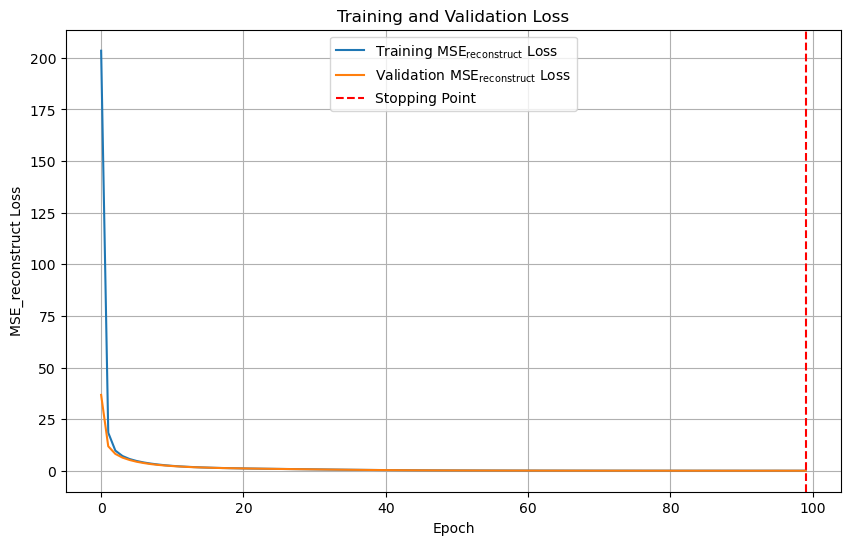

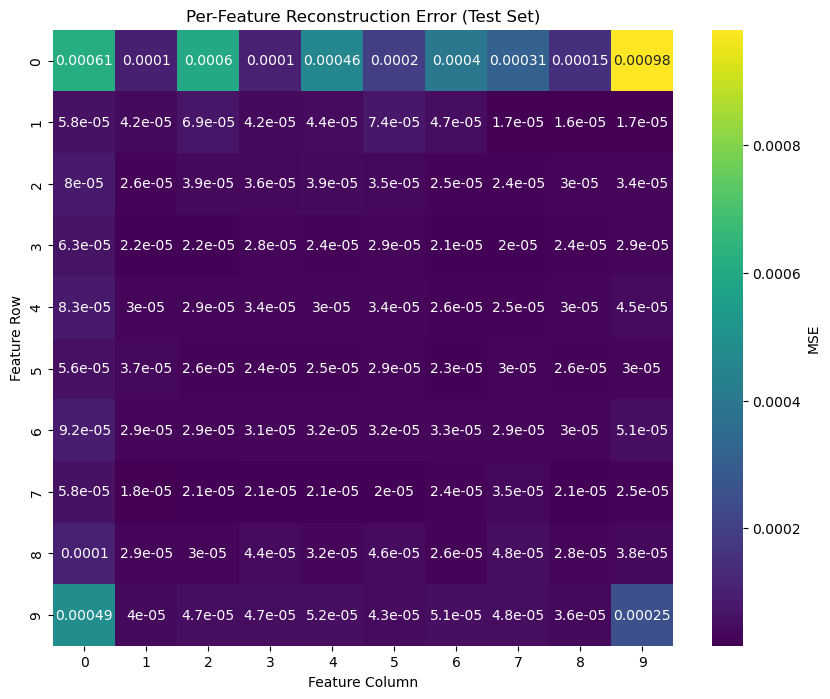

In [14]:
# Initialise the model, loss function, and optimiser
model = UNet()
criterion = MSEReconstructLoss()
optimiser = optim.Adam(model.parameters(), lr=1e-3)

print("Task 1.1: U-Net for dimensionality reduction")
print("=" * 50)

history = training_loop(train_loader, val_loader, max_num_epochs=100, max_patience=5)

# Plot the learning curves
plt.figure(figsize=(10, 6))
plt.plot(history['training_loss'], label=r'$\text{Training MSE}_{\text{reconstruct}}$ Loss')
plt.plot(history['validation_loss'], label=r'$\text{Validation MSE}_{\text{reconstruct}}$ Loss')
plt.axvline(x=history['best_epoch'], color='r', linestyle='--', label='Stopping Point')
plt.xlabel('Epoch')
plt.ylabel('MSE_reconstruct Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Compute the per-feature reconstruction error on the test set
model.eval()
test_reconstructions = []

with torch.no_grad():
    for inputs, _ in test_loader:
        outputs = model(inputs)
        test_reconstructions.append(outputs.numpy())

test_reconstructions = np.vstack(test_reconstructions).reshape(-1, 10, 10)
X_test_np = X_test.reshape(-1, 10, 10)

# Calculate the per-feature MSE as defined in the PDF
per_feature_mse = np.zeros((10, 10))
for i in range(10):
    for j in range(10):
        per_feature_mse[i, j] = np.mean((X_test_np[:, i, j] - test_reconstructions[:, i, j]) ** 2)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(per_feature_mse, annot=True, cmap='viridis', cbar_kws={'label': 'MSE'})
plt.title('Per-Feature Reconstruction Error (Test Set)')
plt.xlabel('Feature Column')
plt.ylabel('Feature Row')
plt.show()

The values shown in the per-feature reconstruction error heatmap are consistently low, indicating that the U-Net CNN architecture is successfully reproducing the high-dimensional input $\mathbf{x}$ from the lower-dimensional representation $\mathbf{\hat{x}}$.

We observe that the errors are greater along the edges, and the greatest at the corners. This is due to using padding, where we surround our 10x10 object with zeros. As such in the convolutional layers, when scanning the 3x3 kernel across the now 12x12 grid, we see more artifical zeros at the edges and corners. More precisely, at corners 5 out of the 9 neighbouring pixels will be artificial zeros; at edges 3 out of the 9 neighbouring pixels will be artificial zeros, and when we are far from the edges and corners all 9 pixels will have real sample data. As such when we take the average of each 3x3 region during the convolution we use more artificial zeros and therefore have greater errors at the edges and corners.

Since we include convolutional layers with padding at the very beginning of the U-Net architecture, the error at the corners and edges will propogate through the model, including to when we generate $\mathbf{\hat{x}}$.

<a name="task-12"></a>

## (1.2) [(index)](#index-task-12)

In [17]:
# Modify the UNet class to work for regression in addition to dimensionality reduction
class UNetMultiTask(nn.Module):
    """
    Create a UNet neural network model, adapted for multitask learning.

    Attributes:
        conv1, conv2, conv3, conv4: The convolutional layers in the UNet arcitechture
        pool: The max-pooling layer in the contracting path
        upconv: The upsampling transposed convolutional layer
        flatten: The flattening layer prior to regression.
        fc: The fully connected layer. This is a linear layer for regression.

    Methods:
        forward(x):
            Initialise the layers for the forward pass.
    """
    def __init__(self):
        super(UNetMultiTask, self).__init__()
        
        # Define the layers for the contracting path
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        
        # Define the layers for the expanding path (reconstruction branch)
        self.upconv = nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv3 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(8, 1, kernel_size=1)
        
        # Define the layers for the regression branch
        self.flatten = nn.Flatten()  # Flatten the encoded features
        self.fc = nn.Linear(16 * 5 * 5, 1)  # Linear layer for regression
        
    def forward(self, x):
        # Forward pass through the contracting path
        x1 = torch.relu(self.conv1(x))
        x_pooled = self.pool(x1)
        x2 = torch.relu(self.conv2(x_pooled))
        
        # Forward pass through the expanding path
        x3 = torch.relu(self.upconv(x2))
        
        # Skip connection: concatenate x1 (the output of the 3x3 convolutional layer and ReLU) to x3 (the output of the expanding path)
        # Intuitively the copy and crop recovers lost info from the contracting path (I think?)
        x4 = torch.cat([x3, x1], dim=1)
        x5 = torch.relu(self.conv3(x4))
        reconstructed = self.conv4(x5)
        
        # Forward pass through the regression branch
        flattened = self.flatten(x2)
        regression = self.fc(flattened)

        # Return the outputs for both tasks 
        return reconstructed, regression

In [18]:
# Modify the MSEReconstructLoss class to work for regression in addition to dimensionality reduction
class MultiTaskLoss(nn.Module):
    """
    MultiTaskLoss class.

    Attributes:
        alpha (float): The hyperparameter alpha.

    Methods:
        forward(reconstruction_output, reconstruction_target, regression_output, regression_target)
            Does a forward pass through the neural network and outputs the loss.
    """
    
    def __init__(self, alpha=0.5):
        super(MultiTaskLoss, self).__init__()
        self.alpha = alpha
    
    def forward(self, reconstruction_output, reconstruction_target, regression_output, regression_target):
        # Calculate MSE_reconstruct
        batch_size = reconstruction_output.shape[0]
        output_flat = reconstruction_output.reshape(batch_size, -1)
        target_flat = reconstruction_target.reshape(batch_size, -1)

        # Calculate the squared differences for each feature
        squared_diff_recon = (output_flat - target_flat) ** 2

        # Sum over the features for each sample
        sample_mse_recon = torch.sum(squared_diff_recon, dim=1)

        # Average over the batch
        mse_reconstruct = torch.mean(sample_mse_recon)
        
        # Calculate MSE_regress
        mse_regress = torch.mean((regression_output - regression_target) ** 2)
        
        # Calculate Multi-task loss
        multi_task_loss = mse_regress + self.alpha * mse_reconstruct

        # Here we return all 3 losses since we will train and select optimal hyperparameters with different loss functions
        return multi_task_loss, mse_regress, mse_reconstruct

In [19]:
def training_loop_multitask(train_loader, val_loader, model, criterion, optimiser, max_num_epochs=1000, max_patience=10, fixed_epochs=None):
    """
    Training loop with early stopping to monitor the validation accuracy.
    Modified to work with multitask learning.

    Parameters:
        train_loader (torch.utils.data.DataLoader): Training DataLoader
        val_loader (torch.utils.data.DataLoader): Validation DataLoader
        model: The model to be trained. This has been added to be able to train separate models without overwriting.
        criterion: The loss to be used in training. This has been added to be able to train separate models without overwriting.
        optimiser: The optimiser to be used in training. This has been added to be able to train separate models without overwriting.
        max_num_epochs (int): Maximum number of epochs
        max_patience (int): max_patience attribute of the EarlyStopping class
        fixed_epochs (int): Provides the number of epochs to train a model for. If not specified, we use EarlyStopping to determine this instead.

    Returns:
        Model, criterion and optimiser.

    """
    # torch.manual_seed(0)

    # Here we have adapted the history dictionary to keep track of the individual losses
    # It also keeps track of the best model so that it can be evaluated
    history = {
        'training_loss': [], 
        'validation_loss': [], 
        'training_regress_loss': [],
        'validation_regress_loss': [],
        'training_reconstruct_loss': [],
        'validation_reconstruct_loss': [],
        'best_epoch': 0,
        'best_val_loss': float('inf'),
        'best_model_state': None
    }
    early_stopping = EarlyStopping(max_patience=max_patience)
    
    if fixed_epochs is not None:
        # Fix the number of epochs if desired
        num_epochs = fixed_epochs
    else:
        # Otherwise set the number of epochs as the maximum allowed
        # This will be checked later on only if fixed_epochs is None
        num_epochs = max_num_epochs
    
    for epoch in range(num_epochs):
        
        tr_loss = 0.0
        val_loss = 0.0
        tr_regress_loss = 0.0
        val_regress_loss = 0.0
        tr_reconstruct_loss = 0.0
        val_reconstruct_loss = 0.0

        # Training
        model.train()
        for inputs, labels, map7_labels in train_loader:
            optimiser.zero_grad() # Setting gradients to zero
            reconstructed, regression = model(inputs)
            loss, regress_loss, reconstruct_loss = criterion(reconstructed, inputs, regression, map7_labels)
            tr_loss += loss.item()
            tr_regress_loss += regress_loss.item()
            tr_reconstruct_loss += reconstruct_loss.item()
            loss.backward() # Computes gradients of the loss
            optimiser.step() # Optimisation step (parameters are updated)
        
        history['training_loss'].append(tr_loss/len(train_loader))
        history['training_regress_loss'].append(tr_regress_loss/len(train_loader))
        history['training_reconstruct_loss'].append(tr_reconstruct_loss/len(train_loader))
        
        # Validation
        model.eval()
        with torch.no_grad():
            for inputs_v, labels_v, map7_labels_v in val_loader:
                reconstructed_v, regression_v = model(inputs_v)
                loss_v, regress_loss_v, reconstruct_loss_v = criterion(reconstructed_v, inputs_v, regression_v, map7_labels_v)
                val_loss += loss_v.item()
                val_regress_loss += regress_loss_v.item()
                val_reconstruct_loss += reconstruct_loss_v.item()
        
        history['validation_loss'].append(val_loss/len(val_loader))
        history['validation_regress_loss'].append(val_regress_loss/len(val_loader))
        history['validation_reconstruct_loss'].append(val_reconstruct_loss/len(val_loader))
        
        # Save best model
        if val_loss/len(val_loader) < history['best_val_loss']:
            history['best_val_loss'] = val_loss/len(val_loader)
            history['best_model_state'] = {k: v.clone() for k, v in model.state_dict().items()}
            history['best_epoch'] = epoch
        
        # Print progress every 10 epochs
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f'Epoch {epoch + 1}/{num_epochs}, '
                  f'Training loss: {tr_loss/len(train_loader)}, '
                  f'Validation loss: {val_loss/len(val_loader)}, '
                  f'Training regress loss: {tr_regress_loss/len(train_loader)}, '
                  f'Training reconstruct loss: {tr_reconstruct_loss/len(train_loader)}')

        # Check for early stopping if fixed_epochs isn't provided
        if fixed_epochs is None:
            early_stopping.step(val_loss / len(val_loader))
            if early_stopping.early_stop:
                print('Early stopping triggered.')
                print(f'Early stopping at epoch {epoch + 1}')
                # history['best_epoch'] = epoch + 1 - early_stopping.max_patience
                break
    
    return history

In [20]:
def evaluate_model(model, test_loader):
    """
    Evaluate model on test set.
    """
    model.eval()
    test_loss = 0.0
    test_regress_loss = 0.0
    test_reconstruct_loss = 0.0
    test_reconstructions = []
    test_predictions = []
    true_values = []

    # Alpha won't affect the evaluation metrics (just using 1.0 here)
    criterion = MultiTaskLoss(alpha=1.0)
    
    with torch.no_grad():
        for inputs, targets, map7_targets in test_loader:
            reconstructed, predictions = model(inputs)
            loss, regress_loss, reconstruct_loss = criterion(reconstructed, inputs, predictions, map7_targets)
            test_loss += loss.item()
            test_regress_loss += regress_loss.item()
            test_reconstruct_loss += reconstruct_loss.item()
            test_reconstructions.append(reconstructed.numpy())
            test_predictions.append(predictions.numpy())
            true_values.append(map7_targets.numpy())
    
    return {
        'test_loss': test_loss/len(test_loader),
        'test_regress_loss': test_regress_loss/len(test_loader),
        'test_reconstruct_loss': test_reconstruct_loss/len(test_loader),
        'reconstructions': np.vstack(test_reconstructions).reshape(-1, 10, 10),
        'predictions': np.vstack(test_predictions).flatten(),
        'true_values': np.vstack(true_values).flatten()
    }

In [21]:
# Numpy arrays to PyTorch tensors
# Also convert y values to tensors for regression
X_train_tensor = torch.tensor(X_train.reshape(-1, 1, 10, 10), dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.reshape(-1, 1, 10, 10), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.reshape(-1, 1, 10, 10), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.reshape(-1, 1), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32)

# Creating training and validation and testing datasets
train_dataset = TensorDataset(X_train_tensor, X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, X_test_tensor, y_test_tensor)

# Creating corresponding DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Training with alpha = 0.1
--------------------------------------------------
Epoch 1/1000, Training loss: 116.89649989687163, Validation loss: 36.97152625189887, Training regress loss: 91.40090676011711, Training reconstruct loss: 254.95593024944438
Epoch 10/1000, Training loss: 22.566324036696862, Validation loss: 23.210778766208225, Training regress loss: 21.97084900428509, Training reconstruct loss: 5.954750414552359
Epoch 20/1000, Training loss: 9.682950521337576, Validation loss: 9.153070343865288, Training regress loss: 9.233301697106198, Training reconstruct loss: 4.49648877670025
Epoch 30/1000, Training loss: 8.603803618200894, Validation loss: 8.564470397101509, Training regress loss: 8.233173197713391, Training reconstruct loss: 3.706304513174912
Epoch 40/1000, Training loss: 8.107246662008352, Validation loss: 8.458950678507486, Training regress loss: 7.803119766301122, Training reconstruct loss: 3.041268883080318
Epoch 50/1000, Training loss: 7.667439008581227, Validation 

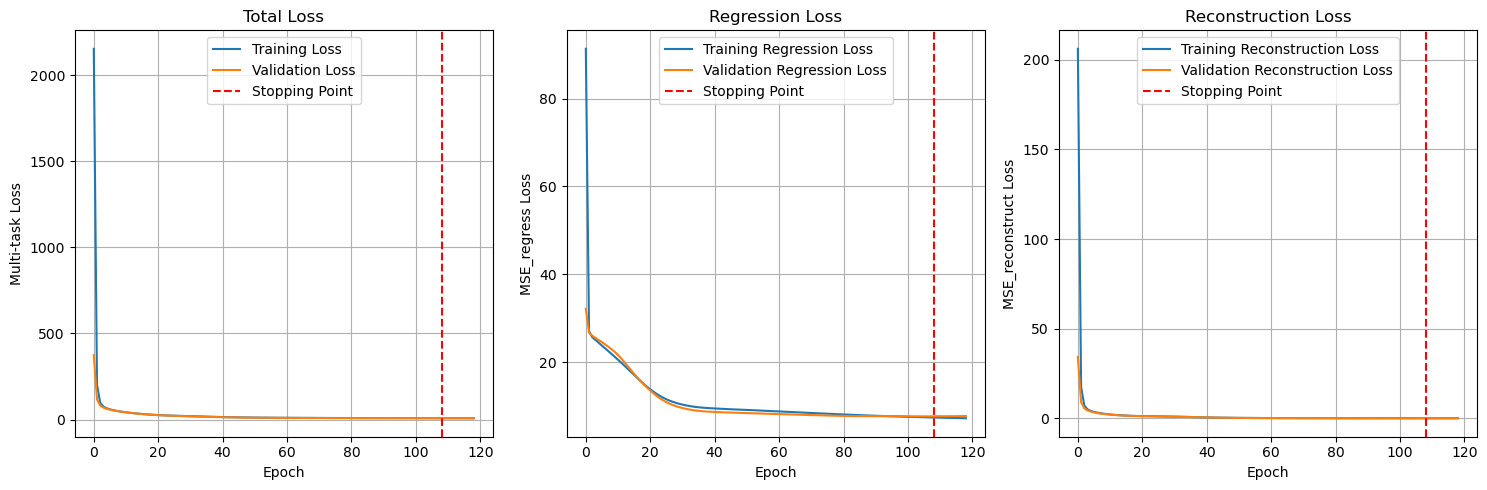

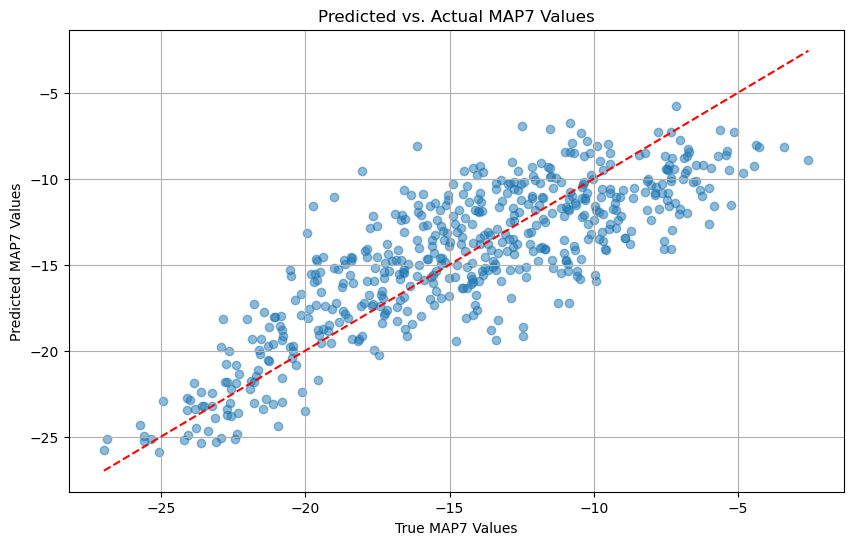

Regression MSE on test set: 7.930113


In [22]:
alpha_values = [0.1, 1, 10]
results = {}

for alpha in alpha_values:
    print(f"\nTraining with alpha = {alpha}")
    print("-" * 50)
    
    # Initialise model, criterion, and optimiser
    model = UNetMultiTask()
    criterion = MultiTaskLoss(alpha=alpha)
    optimiser = optim.Adam(model.parameters(), lr=1e-3)
    
    # Train model
    history = training_loop_multitask(train_loader, val_loader, model, criterion, optimiser,max_num_epochs=1000, max_patience=10)
    
    # Load best model
    model.load_state_dict(history['best_model_state'])
    
    # Evaluate on validation set
    val_results = evaluate_model(model, val_loader)
    
    # Store results
    results[alpha] = {'history': history, 'val_results': val_results, 'model_state': {k: v.clone() for k, v in history['best_model_state'].items()}}
    
    print(f"Alpha = {alpha}, Best validation loss: {history['best_val_loss']:.6f}")
    print(f"Validation regression loss: {val_results['test_regress_loss']:.6f}")
    print(f"Validation reconstruction loss: {val_results['test_reconstruct_loss']:.6f}")

# Find best alpha based on the regression loss
best_alpha = min(results.keys(), key=lambda a: results[a]['val_results']['test_regress_loss'])
print("\n" + "=" * 80)
print(f"Best alpha value: {best_alpha}")
print("=" * 80)

best_epoch = results[best_alpha]['history']['best_epoch']
print(f"Best number of epochs found: {best_epoch + 1}")

# Retrain the model with the best alpha value using all training data
print("Retraining best model")
# Combine training and validation data
combined_X = torch.cat([X_train_tensor, X_val_tensor], dim=0)
combined_y = torch.cat([y_train_tensor, y_val_tensor], dim=0)
combined_dataset = TensorDataset(combined_X, combined_X, combined_y)
combined_loader = DataLoader(combined_dataset, batch_size=32, shuffle=False)

# Initialise a new model with the best alpha
final_model = UNetMultiTask()
final_criterion = MultiTaskLoss(alpha=best_alpha)
final_optimiser = optim.Adam(final_model.parameters(), lr=1e-3)

# Here we train for the exact number of epochs
final_history = training_loop_multitask(combined_loader,val_loader,final_model,final_criterion,final_optimiser,fixed_epochs=best_epoch + 1)

# Use the final retrained model for evaluation
final_test_results = evaluate_model(final_model, test_loader)
best_model = final_model
test_results = final_test_results

print(f"Final test results after retraining with best alpha ({best_alpha}):")
print(f"Test loss: {final_test_results['test_loss']:.6f}")
print(f"Test regression loss: {final_test_results['test_regress_loss']:.6f}")

# Plot tbe training and validation losses for the best alpha
best_history = results[best_alpha]['history']

plt.figure(figsize=(15, 5))
# Plot the total loss
plt.subplot(1, 3, 1)
plt.plot(best_history['training_loss'], label='Training Loss')
plt.plot(best_history['validation_loss'], label='Validation Loss')
plt.axvline(x=best_history['best_epoch'], color='r', linestyle='--', label='Stopping Point')
plt.xlabel('Epoch')
plt.ylabel('Multi-task Loss')
plt.title('Total Loss')
plt.legend()
plt.grid(True)

# Plot the regression loss
plt.subplot(1, 3, 2)
plt.plot(best_history['training_regress_loss'], label='Training Regression Loss')
plt.plot(best_history['validation_regress_loss'], label='Validation Regression Loss')
plt.axvline(x=best_history['best_epoch'], color='r', linestyle='--', label='Stopping Point')
plt.xlabel('Epoch')
plt.ylabel('MSE_regress Loss')
plt.title('Regression Loss')
plt.legend()
plt.grid(True)

# Plot the reconstruction loss
plt.subplot(1, 3, 3)
plt.plot(best_history['training_reconstruct_loss'], label='Training Reconstruction Loss')
plt.plot(best_history['validation_reconstruct_loss'], label='Validation Reconstruction Loss')
plt.axvline(x=best_history['best_epoch'], color='r', linestyle='--', label='Stopping Point')
plt.xlabel('Epoch')
plt.ylabel('MSE_reconstruct Loss')
plt.title('Reconstruction Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluate on test set
best_model.eval()
test_reconstructions = []
test_predictions = []
true_values = []
with torch.no_grad():
    for inputs, _, targets in test_loader:
        reconstructed, predictions = best_model(inputs)
        test_reconstructions.append(reconstructed.numpy())
        test_predictions.append(predictions.numpy())
        true_values.append(targets.numpy())
test_reconstructions = np.vstack(test_reconstructions).reshape(-1, 10, 10)
test_predictions = np.vstack(test_predictions).flatten()
true_values = np.vstack(true_values).flatten()

# Plot the predicted values against the actual MAP7 values
plt.figure(figsize=(10, 6))
plt.scatter(true_values, test_predictions, alpha=0.5)
plt.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], 'r--')
plt.xlabel('True MAP7 Values')
plt.ylabel('Predicted MAP7 Values')
plt.title('Predicted vs. Actual MAP7 Values')
plt.grid(True)
plt.show()

# Print regression MSE
mse_regress = np.mean((test_predictions - true_values) ** 2)
print(f"Regression MSE on test set: {mse_regress:.6f}")

The loss function $L_{\text{multi}} = MSE_{\text{regress}} + \alpha MSE_{\text{reconstruct}}$ corresponds to a combination of the losses from the two tasks, the reconstruction of $\mathbf{\hat{x}}$ and the regression of the MAP7 target gene. The reconstruction loss is the same loss as in q1.1 and assesses how well we are able to create a lower-dimensional representation of $\mathbf{x}$ and then reconstruct it in the original dimensions. The regression loss corresponds to how well we are able to predict the MAP7 gene.

The parameter $\alpha$ determines how much to weight each task, i.e. which of the regression and reconstruction objectives to focus on more. When $\alpha = 1$ we weight both tasks equally; when $\alpha > 1$ the reconstruction loss is penalised more heavily, so when training the U-Net model it focuses more on reconstruction accuracy; when $\alpha < 1$ the regression loss is penalised more heavily, so when training the U-Net model it focuses more on the regression accuracy. This relies on the fact that neural networks aim to minimise the loss function.

Due to the stochasticity in the Adam optimisation algorithm, the value of $\alpha$ that we get from the hyperparameter tuning varies. We see that when we train the model multiple times, we find $\alpha = 10$ as the optimal hyperparameter more often than the other 2 values. This corresponds to weighting the reconstruction task more heavily.

First note that as in Section 7.7 of Goodfellow, Bengio, Courville Deep learning (2016) we know that multi-task learning depends on the assumption that both tasks rely on a "common pool of factors that explain the variations in the input". This is exactly the case in our U-Net model: dimensionality reduction and reconstruction relies on understanding and capturing the most important patterns in the dataset, which in turn will lead to greater accuracy in regression for a chosen feature, for example the MAP7 gene.

We have two competing persepctives:

- Consider the plots above. We can see that the regression loss decays more slowly than the reconstruction loss and as such the regression task is the more difficult of the two. The reason behind this is because the regression layer acts on the lower-dimensional representation of $\mathbf{x}$, whereas in the reconstruction task we have the copy and crop/skip connection. This acts to transfer feature maps from the contracting path to the expanding path, reintroducing information that was lost during the dimensionality reduction. Therefore we should choose a smaller $\alpha$ to focus on the more difficult task; regression.

- As in Section 7.7 of Goodfellow, Bengio, Courville Deep learning (2016) we know that multi-task learning depends on the assumption that both tasks rely on a "common pool of factors that explain the variations in the input". This is exactly the case in our U-Net model: dimensionality reduction and reconstruction relies on understanding and capturing the most important patterns in the dataset, which in turn will lead to greater accuracy in regression for a chosen feature, for example the MAP7 gene. Since better dimensionallity reduction and reconstruction leads to better regression on the MAP7 gene, but not necessarily the other way round (since regression on MAP7 only considers one feature) we should choose a larger $\alpha$ to focus on the dimensionality reduction and reconstruction task.

The literature is clear; the most important factor in the success of multi-task learning is the relationship between the features/information involved in both tasks. As such the second persepctive seems more semsible, and aligns with the fact that we see $\alpha = 10$ being selected more often. However if the random samples are chosen such that the features do not align (perhaps due to random noise/measurement noise) then the first persepctive shows why we may sometimes get vallues of 0.1 or 1.

In [23]:
def calculate_r2(y_pred, y_true):
    """
    Calculate the r^2 value between two arrays.
    
    Parameters:
        y_pred (np.array): Predicted values
        y_true (np.array): True values
    
    Returns:
        r2 (float): r^2 value.
    """

    # Calculate mean of true values
    y_mean = np.mean(y_true)
    
    # Calculate the total sum of squares
    ss_tot = np.sum((y_true - y_mean)**2)
    
    # Calculate the residual sum of squares
    ss_res = np.sum((y_true - y_pred)**2)
    
    # Calculate the r^2 value
    r2 = 1 - ss_res/ss_tot
    
    return r2

r2_score = calculate_r2(test_predictions, true_values)
print(f'r^2 score on test set: {r2_score}')

r^2 score on test set: 0.6833135187625885


The $R^{2}$ score is consistently in the approximate range $[0.68,0.70]$ when running the algorithm multiple times. This suggests that the multi-task model is able to perform the regression task with a reasonable level of accuracy, explaining most (around 70%) of the variance in the data.

Despite regression being a relatively simple deep learning task to carry out using CNNs, we might actually expect a regular CNN to perform worse than this since our dataset is quite small for deep-learning standards ($N_{\text{train}}=1848$). As such, our model has been able to leverage the dimensionality reduction task to learn the structures and patterns in the features, aiding the regression task and improving the regression accuracy.

<a name="task-2"></a>

# Task 2: Graph-based learning [(index)](#index-task-2)

In [27]:
# Dataset upload #
import pandas as pd
dataset = pd.read_csv("gene_expression_transcriptomic_data.csv")

X = dataset.iloc[:400, :10].values # extract the first 400 rows and 10 columns
treatment = dataset.iloc[:, 101].values[:400, ] # extract the corresponding 400 treatment labels

<a name="task-21"></a>

## (2.1) [(index)](#index-task-21)

In [29]:
S = np.zeros((400,400))
X_norms = np.linalg.norm(X, axis=1, keepdims=True)
S = (X@X.T)/(X_norms@X_norms.T)

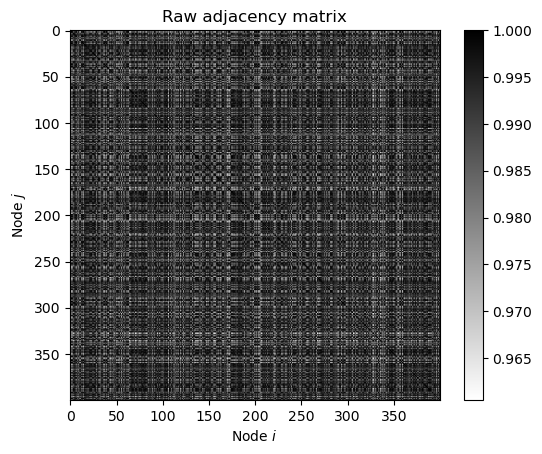

In [30]:
# plot raw adjacency matrix
fig, ax = plt.subplots(1)
im = ax.imshow(S, cmap="binary")
plt.colorbar(im)
ax.set(title="Raw adjacency matrix", xlabel=r"Node $i$", ylabel=r"Node $j$")
plt.show()

In [31]:
# check properties of graph
print("Graph is undirected:", np.array_equal(S, S.T))
print("Graph is unweighted:", np.array_equal(np.unique(S), np.arange(2)))

Graph is undirected: True
Graph is unweighted: False


In [32]:
deltas = np.linspace(S.min(), S.max(), 200)

In [33]:
print(S.min())
print(S.max())

0.9605549292289124
1.0000000000000004


In [34]:
def sparsify(S, delta):
    A = S.copy()
    # Find all indices where A<delta
    mask = A<delta  
    A[mask] = 0
    # Along the diagonal we have all 0s
    np.fill_diagonal(A,0)
    return A

In [35]:
def compute_components(A):
    """Find connected components using DFS."""
    N = A.shape[0]
    visited = np.zeros(N, dtype=bool)
    components = []
    
    def dfs(node, component):
        stack = [node]
        while stack:
            v = stack.pop()
            if not visited[v]:
                visited[v] = True
                component.append(v)
                stack.extend(np.where(A[v] > 0)[0])
    
    for node in range(N):
        if not visited[node]:
            component = []
            dfs(node, component)
            components.append(component)
    
    return components

In [36]:
def compute_sparsity(A):
    num_edges = np.count_nonzero(A)/2
    max_edges = A.shape[0]*(A.shape[0]-1)/2
    return num_edges/max_edges

In [37]:
n_components = []
sparsity_levels = []

for delta in deltas:
    A_delta = sparsify(S,delta)
    components = compute_components(A_delta)
    n_components.append(len(components))
    sparsity_levels.append(compute_sparsity(A_delta))

In [38]:
delta_star = None

# Iterate through all the deltas
for delta in deltas:
    A_delta = sparsify(S,delta)
    components = compute_components(A_delta)
    # If the graph is disconnected, break from the loop
    # This is because we do not want this value of delta
    # We want the largest delta which keeps the graph connected (i.e. number of components = 1)
    if len(components) > 1:
        break
    # If we haven't broken out from the loop, store the value of delta in delta_star
    # By the end of the loop/when the loop is broken, delta_star will have the largest delta making the graph connected
    delta_star = delta

print("Optimal delta*:", delta_star)

Optimal delta*: 0.9990089178198224


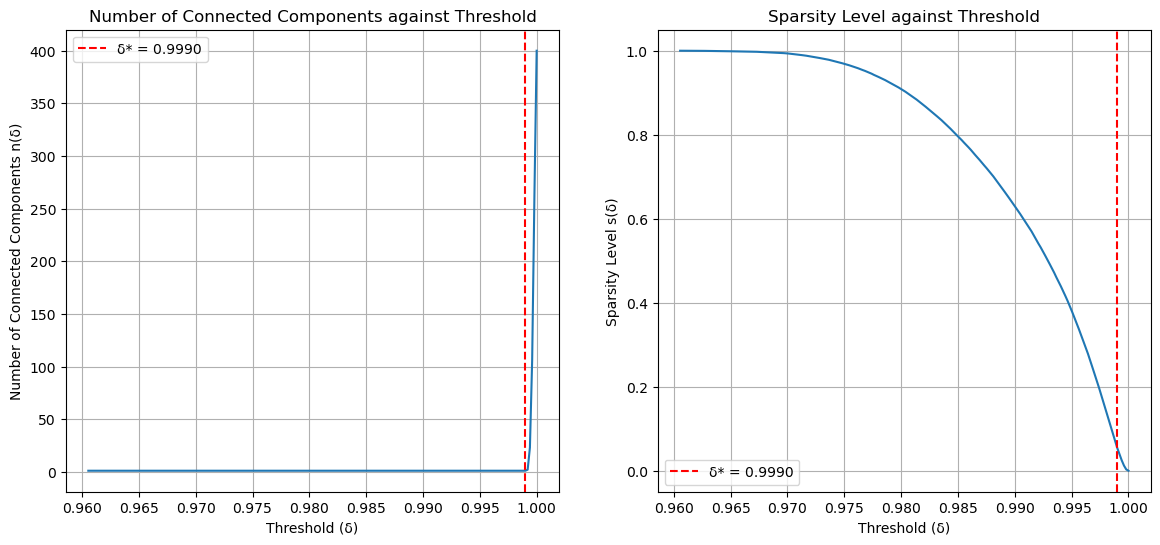

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

def plot_data(ax, x, y, ylabel, title):
    ax.plot(x, y)
    ax.axvline(x=delta_star, color='red', linestyle='--', label=f'δ* = {delta_star:.4f}')
    ax.set(xlabel='Threshold (δ)', ylabel=ylabel, title=title)
    ax.grid(True)
    ax.legend()

plot_data(axes[0], deltas, n_components, 'Number of Connected Components n(δ)', 'Number of Connected Components against Threshold')
plot_data(axes[1], deltas, sparsity_levels, 'Sparsity Level s(δ)', 'Sparsity Level against Threshold')

plt.show()

$S$ represents the adjacency matrix of $G_{\text{dense}}$. The graph $G_{\text{dense}}$ therefore represents how similar each sample of the 10 genes are, with samples being represented by nodes and similar samples being connected with an edge with greater weight.

Originally, $G_{\text{dense}}$ is complete. As $\delta$ increases, we sparsify $G_{\text{dense}}$ by keeping only the strongest weighted edges (as well as discarding loops since they don't affect connectedness). The graph $G^{\delta}$ stays connected (i.e. $n(\delta) =1$) for values of $\delta < \delta^{\star}$ (by definition of $\delta^{\star}$). However, the value of $\delta^{\star}=0.9990$ is only very slightly below $S_{\text{max}} = 1.0$, and $n(\delta)$ grows extremely sharply once $\delta > \delta^{\star}$. This indicates that the most important weights in conencting the graph are of weight just above $\delta^{\star}$. Furthermore, it indicates that we have a sort of 'hub-and-spoke' or 'star' structure to $G_{\text{dense}}$, where we have a few central nodes which the majority of the other nodes are connected to. We will refer to these as 'central nodes' and 'outer nodes' henceforth.

The second graph of $s(\delta)$ against $\delta$ however shows that the sparsity level decays relatively steadily as $\delta$ increases. By definition of the sparsity level, the number of edges in $G_{\text{dense}}$ must decrease somewhat constantly too, despite the sharp increase in $n(\delta)$ just beyond $\delta^{\star}$. Importantly the sparsity decreases despite the number of connected components remaining at 1; see $\delta \in [0.960,\delta^{\star})$. This indicates that the edges connecting outer nodes to outer nodes are of smaller weight than the edges connecting the outer nodes to the central nodes. Since the sparsity level decays relatively steadily compared to the number of connected components, we see that the weights of edges between two outer nodes is roughly uniformly distributed on $[\min_{e \in E} w(e),\delta^{\star}]$. 

We therefore have a strong pattern/similarity between the samples, with the central nodes corresponding to a few cell samples being highly representative of the entire dataset, and the rest of the samples being slight variations of these. These differences could correspond to different stages of the cell cycle, where perhaps the central nodes correspond to measurements being taken in the middle/peak of a particular stage cell cycle, or to whether the drug treatment was given or not.

We will now investigate if these differences are due to the drug treatment being given or not.

In [41]:
G = sparsify(S, delta_star)
print('The sparsity level of G is', compute_sparsity(G))

The sparsity level of G is 0.0543734335839599


In [42]:
print(G)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.99989861 ... 0.         0.         0.        ]
 [0.         0.99989861 0.         ... 0.         0.99905143 0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.99905143 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [43]:
# Here we encode the nodes by treatment
value_to_type = {0 : "0", 1 : "1"}

In [44]:
# Code below copied from Graphs Notebook
# we define node colours consistent with the plot above
cmap = plt.get_cmap("tab10")
color_type = [cmap(i) for i in treatment]  # Use treatment labels for coloring

# compute degrees
d = G.sum(axis=0)

# define diagonal degree matrix
D = np.diag(d)

# compute combinatorial Laplacian
L = D - G

# compute square root of inverse diagonal degree matrix
D_sqrt_inv = np.diag(1/np.sqrt(d))

# compute symmetric normalised Laplacian
L_s = D_sqrt_inv @ L @ D_sqrt_inv

# the square-root of the degree vector is the zero eigenvector to eigenvalue 0
np.allclose(L_s @ np.sqrt(d),np.zeros(G.shape[0]))

# compute eigen decomposition using the fact that L_s is symmetric
eigenvals, eigenvecs = np.linalg.eigh(L_s)

# sort eigenvalues and corresponding eigenvector
eigenvecs = eigenvecs.T[np.argsort(eigenvals)]
eigenvals = np.sort(eigenvals)

# get second (Fiedler) and third eigenvectors
v2 = eigenvecs[1]
v3 = eigenvecs[2]

# normalise coordinates
x = D_sqrt_inv @ v2
y = D_sqrt_inv @ v3

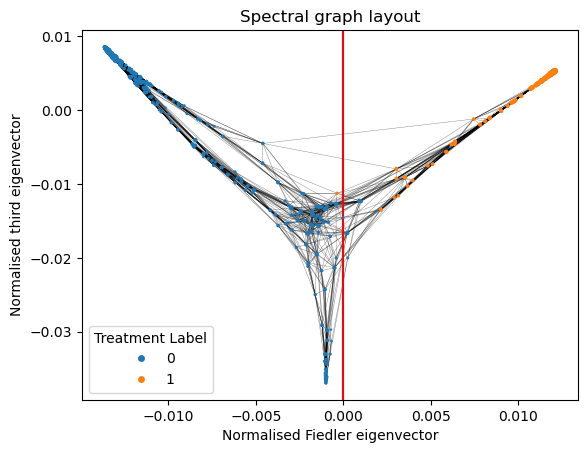

In [45]:
# Function and plotting code copied from Graphs Notebook
def plot_graph(adjacency, x_coord, y_coord, node_size, node_color):
    """Plot undirected graph.

    Parameters:
        adjacency (np.array): N x N adjacency matrix.
        x_coord (np.array): X-coordinates for N nodes.
        y_coord (np.array): Y-coordinates for N nodes.
        node_size (np.array): Size for each of the N nodes.
        node_color (np.array): Color for each of the N nodes.
    """

    # plot
    fig, ax = plt.subplots(1)

    # plot edges
    for i in range(adjacency.shape[0]):
        for j in range(i+1,adjacency.shape[0]):
            if adjacency[i,j] > 0:
                ax.plot([x_coord[i],x_coord[j]],[y_coord[i],y_coord[j]], color="black", alpha=0.5, linewidth=0.3)

    # plot nodes
    scatter = ax.scatter(x_coord,y_coord,s=0.2*node_size, c=node_color, zorder=10)

    return ax

# plot graph
ax = plot_graph(adjacency=G, x_coord=x, y_coord=y, node_size=d, node_color=color_type)

# set labels
ax.set(xlabel="Normalised Fiedler eigenvector", ylabel="Normalised third eigenvector", title="Spectral graph layout")

# plot cut induced by Fiedler eigenvector
ax.axvline(x=0, color="red")

# create legend for node types
types_legend = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=cmap(value)) for value, label in value_to_type.items()]
plt.legend(handles=types_legend, title='Treatment Label');

The plot above shows the spectral graph layout for $G = G^{\left( \delta^{\star} \right)}$. We first note that at $\delta^{\star}$ the graph sparsity is approximately 0.05, meaning around only 5% of the number of edges in $G_{\text{dense}}$ have weight greater than $\delta^{\star}$.

These 5% of edges represent the 'most important' edges in the keeping the graph connected. We can see that we can bipartition the graph based on whether the drug treatment was given to the sampled cell or not, depending on the value of the normalised Fiedler eigenvector; if it is greater than 0 then the drug was given, and if it less than 0 then the drug was not given.

Furthermore we see that we have much more edges between nodes of the same community (treatment given or treatment not given) compared to edges between the two communities.

This indicates that the treatment being given or not has a direct impact on the structure of the similarity graph, and as such indicates that we have two clusters of similar cell samples; those which have been treated with the drug and those that have not. This aligns with our previous hypothesis about the 'hub-and-spoke'/'star' structure of $G_{\text{dense}}$; it is likely we have two central nodes, which could represent the 'prototypical' or average gene expression of a cell treated and not treated with the drug.

<a name="task-22"></a>

## (2.2) [(index)](#index-task-22)

In [48]:
def compute_degree_centrality(A):
    # I think axis=1 makes more sense here but it's symmetric so doesn't matter
    # d = A.sum(axis=0) 
    # E = int(A.sum()/2)
    # Since we are working with a weighted graph we have to make some adjustments from the notebook
    d = np.sum(A>0,axis=0)
    E = np.count_nonzero(A)/2
    return d/(2*E)

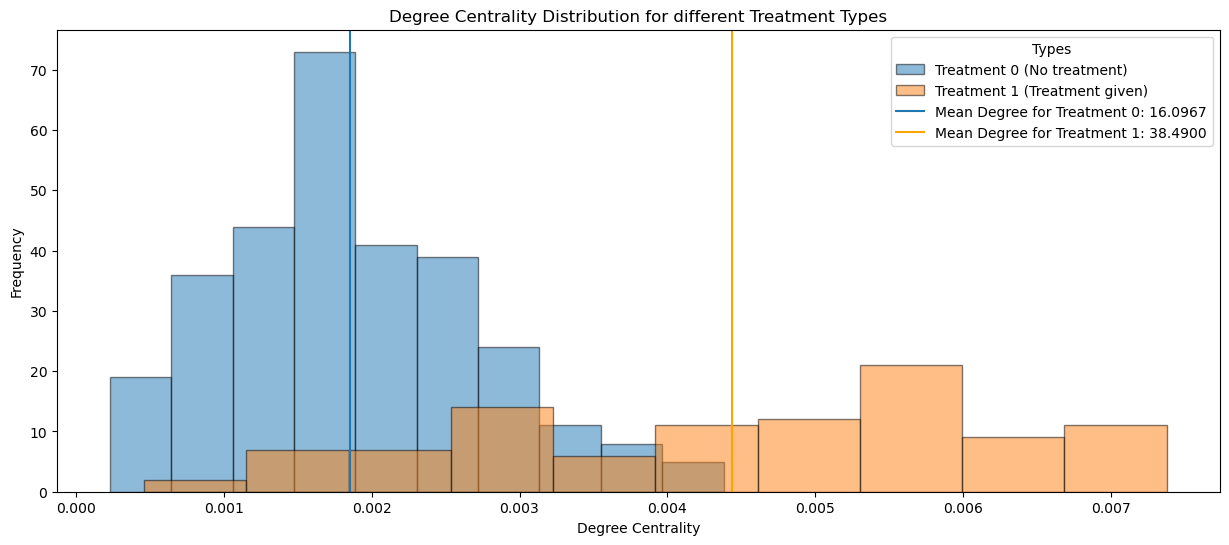

Mean Degree for Treatment 0:  16.096666666666664
Mean Degree for Treatment 1:  38.49


In [108]:
centrality = compute_degree_centrality(G)
E = np.count_nonzero(G)/2

# Plotting code copied from Graphs Notebook
fig, ax = plt.subplots(1, figsize = (15,6))
ax.hist(centrality[treatment==0],alpha=0.5, edgecolor='black', label=r"Treatment 0 (No treatment)")
ax.hist(centrality[treatment==1],alpha=0.5, edgecolor='black', label=r"Treatment 1 (Treatment given)")
ax.set(xlabel="Degree Centrality",ylabel="Frequency",title="Degree Centrality Distribution for different Treatment Types")
ax.axvline(centrality[treatment==0].mean(), label = f"Mean Degree for Treatment 0: {centrality[treatment==0].mean()*2*E:.4f}")
ax.axvline(centrality[treatment==1].mean(), label = f"Mean Degree for Treatment 1: {centrality[treatment==1].mean()*2*E:.4f}", color = "orange")
ax.legend(title="Types")
plt.show()

print('Mean Degree for Treatment 0: ',centrality[treatment==0].mean()*2*E)
print('Mean Degree for Treatment 1: ',centrality[treatment==1].mean()*2*E)

Here we have plotted histograms for the degree centrality distributions of $G$ for the treated and untreated cells (separately).

We observe that the degree centrality for the non-treated cells is, on average, lower than that of the treated cells (16.10 vs 38.49). This indicates that, when the treatment is given, we have a greater number of edges in the graph $G$. Since this is the histogram for the graph $G$ with only the most important edges for connectedness, we note that when the treatment is given more edges have weight greater than $\delta^{\star}$. This means that the samples within the set of treated cells are more similar to each other than those within the set of untreated cells. This could indicate that, due to the treatment, cells are further distinguished by their gene expressions. This could be due to the cancer marking MAP7 gene but also other changes in gene expressions due to the mechanism of the drug/the cancer being reduced. For the non-treated cells we have less edges in $G$, perhaps because some are in fact cancerous and others are not, meaning the cancerous cells are *not* treated, leading to more dissimilarity. 

The non-treated cells also have a much more densely concentrated degree centrality around its mean, whereas the treated cells have a wider distribution. This might indicate that the drug being tested does not have a uniform/reliable effect on cells; perhaps it works sometimes, and other times it does not, and maybe the level of effectiveness of the drug also varies. This could lead to some cancerous cells that are not treated having a lower degree centrality than the rest, and as such the distribution is wider.